# AI LAB 4: TRANSFER LEARNING

**ResNet50 Binary Classification**


### Библиотеки и установка зависимостей

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")
BIN = True
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

In [3]:
def checkBin(filename):
    if filename[0].islower():
        return "Dog"
    return "Cat"

In [4]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, bin=False):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.bin = bin

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.bin:
                self.labels = [checkBin(path.name) for path in self.files]
            else:
                self.labels = ["_".join(path.name.split("_")[0:-1]) for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
root = './'
_ = OxfordIIITPet(root, download=True)

100%|██████████| 791918971/791918971 [00:55<00:00, 14294955.97it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7553709.96it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [7]:
DIR = Path('./oxford-iiit-pet/images')

files = sorted(list(DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

if BIN:
    y = [checkBin(path.name) for path in files]
else:
    y = ["_".join(path.name.split("_")[0:-1]) for path in files]
print(y)

train_data, val_data = train_test_split(files, train_size=0.8, stratify=y)

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

In [9]:
train_dataset = PetFacesDataset(train_data, "train", bin=BIN)
val_dataset   = PetFacesDataset(val_data, "val", bin=BIN)

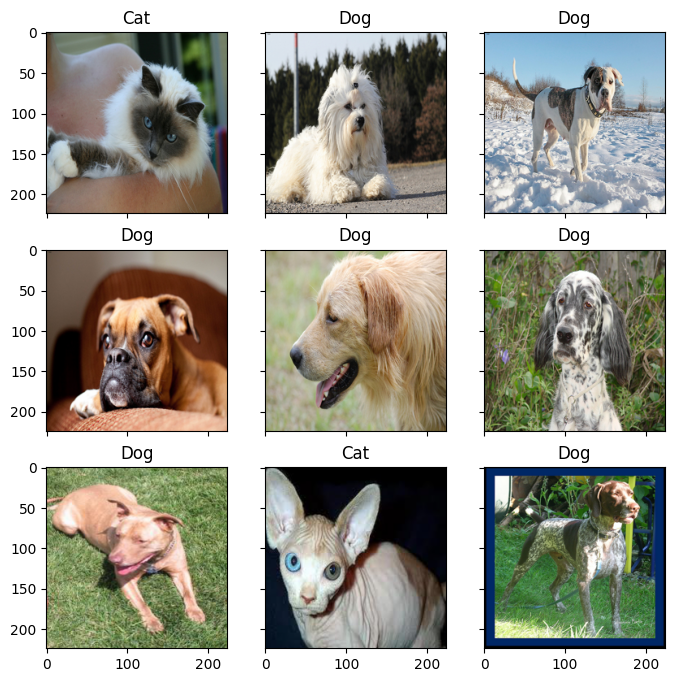

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Код для обучения модели

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    processed_data = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects_top3 = 0.0
    running_corrects_top5 = 0.0
    processed_size = 0.0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            preds_top3 = preds
            preds_top5 = preds
            try:
                preds_top3 = torch.topk(outputs, 3).indices
                preds_top5 = torch.topk(outputs, 5).indices
            except:
                "ok"
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top3[i]:
                running_corrects_top3 += 1
                # print(labels.data[i])
                # print(preds_top3[i])
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top5[i]:
                running_corrects_top5 += 1
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    val_acc_top3 = running_corrects_top3 / processed_size
    val_acc_top5 = running_corrects_top5 / processed_size
    return val_loss, val_acc, val_acc_top3, val_acc_top5

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    val_acc_top3 {v_acc_3:0.4f} val_acc_top5 {v_acc_5:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            model.eval()
            val_loss, val_acc, val_acc_3, val_acc_5 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, val_acc_3, val_acc_5))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_3=val_acc_3,\
            v_acc_5=val_acc_5))
    return history

In [14]:
def predict(model, test_loader):
    logits = []
    with torch.inference_mode():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Обучение

Посмотрим на количество данных и число классов.

In [15]:
print(f"Количествово классов: {len(np.unique(np.array(y)))}")
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Количествово классов: 2
Размер обучающей выборки: 5912
Размер валидационной выборки: 1478


В этом блокноте рассматривается **ResNet50** для **бинарной** классификации

In [16]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Поменяем выход последнего слоя на количество классов (в нашем случае - 37)

In [17]:
model.fc = nn.Linear(2048, len(np.unique(np.array(y))))

In [18]:
model = model.to(DEVICE)

Обучаем сеть

In [19]:
history = train(train_dataset, val_dataset, model=model, epochs=7, batch_size=128)

epoch:  14%|█▍        | 1/7 [02:32<15:12, 152.03s/it]


Epoch 001 train_loss: 0.1416 val_loss 0.1604     train_acc 0.9416 val_acc 0.9493     val_acc_top3 0.9493 val_acc_top5 0.9493


epoch:  29%|██▊       | 2/7 [04:59<12:26, 149.26s/it]


Epoch 002 train_loss: 0.0806 val_loss 0.1621     train_acc 0.9726 val_acc 0.9344     val_acc_top3 0.9344 val_acc_top5 0.9344


epoch:  43%|████▎     | 3/7 [07:27<09:54, 148.70s/it]


Epoch 003 train_loss: 0.0537 val_loss 0.1865     train_acc 0.9794 val_acc 0.9594     val_acc_top3 0.9594 val_acc_top5 0.9594


epoch:  57%|█████▋    | 4/7 [09:55<07:25, 148.64s/it]


Epoch 004 train_loss: 0.0465 val_loss 0.2845     train_acc 0.9834 val_acc 0.9181     val_acc_top3 0.9181 val_acc_top5 0.9181


epoch:  71%|███████▏  | 5/7 [12:23<04:56, 148.35s/it]


Epoch 005 train_loss: 0.0370 val_loss 0.0377     train_acc 0.9890 val_acc 0.9851     val_acc_top3 0.9851 val_acc_top5 0.9851


epoch:  86%|████████▌ | 6/7 [14:56<02:29, 149.82s/it]


Epoch 006 train_loss: 0.0122 val_loss 0.0330     train_acc 0.9970 val_acc 0.9871     val_acc_top3 0.9871 val_acc_top5 0.9871


epoch: 100%|██████████| 7/7 [17:25<00:00, 149.29s/it]


Epoch 007 train_loss: 0.0072 val_loss 0.0300     train_acc 0.9985 val_acc 0.9858     val_acc_top3 0.9858 val_acc_top5 0.9858


Построим кривые обучения

In [20]:
loss, acc, val_loss, val_acc, val_acc_3, val_acc_5 = zip(*history)

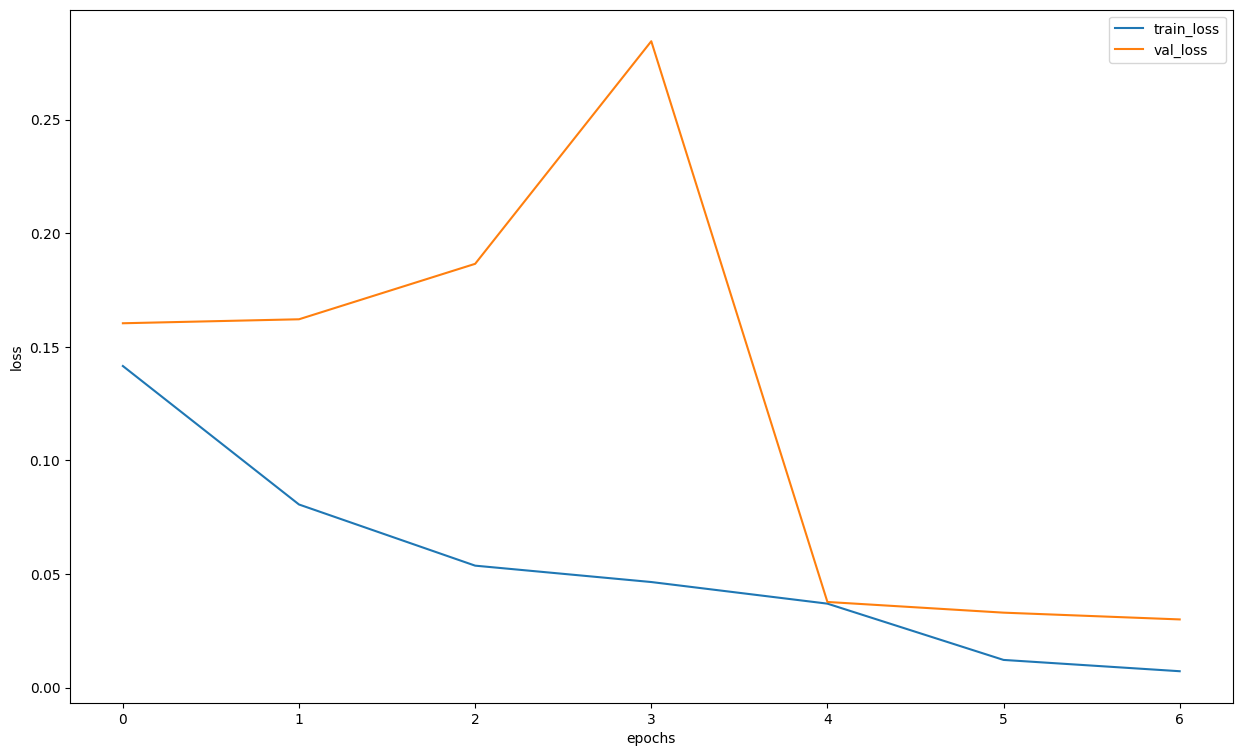

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

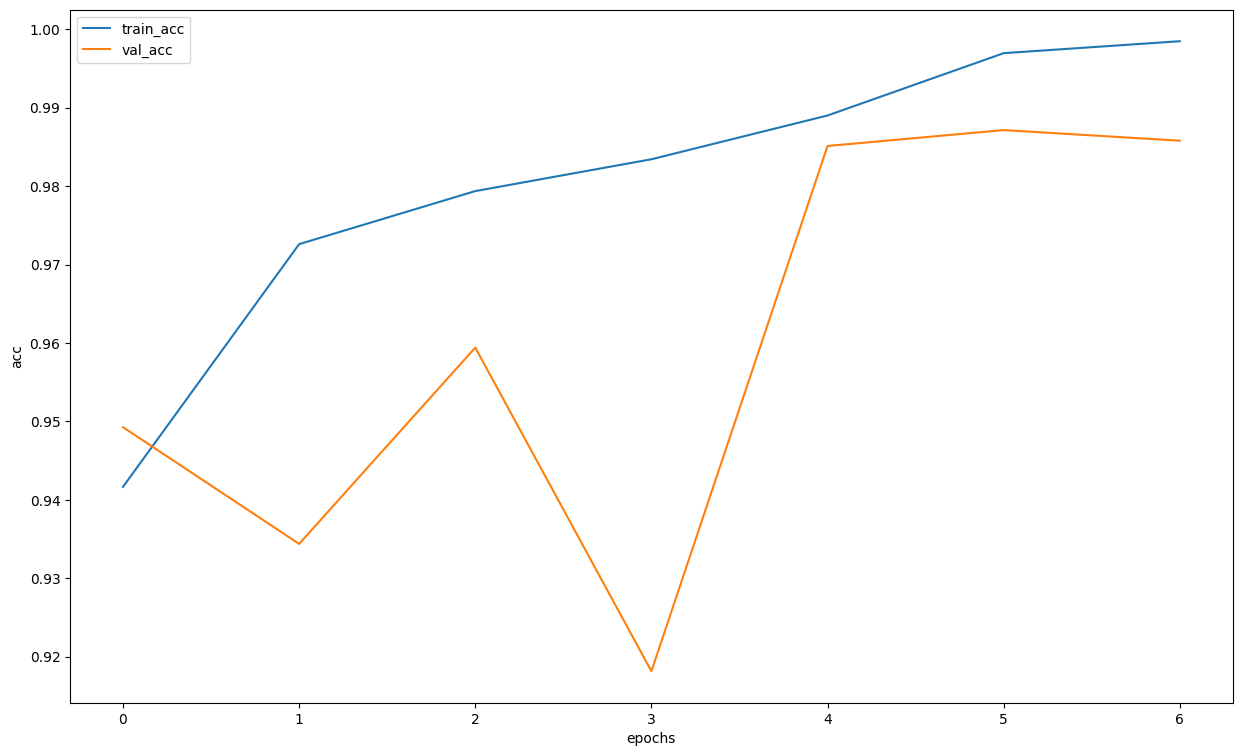

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Визуализация предсказаний нейронной сети

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.inference_mode():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

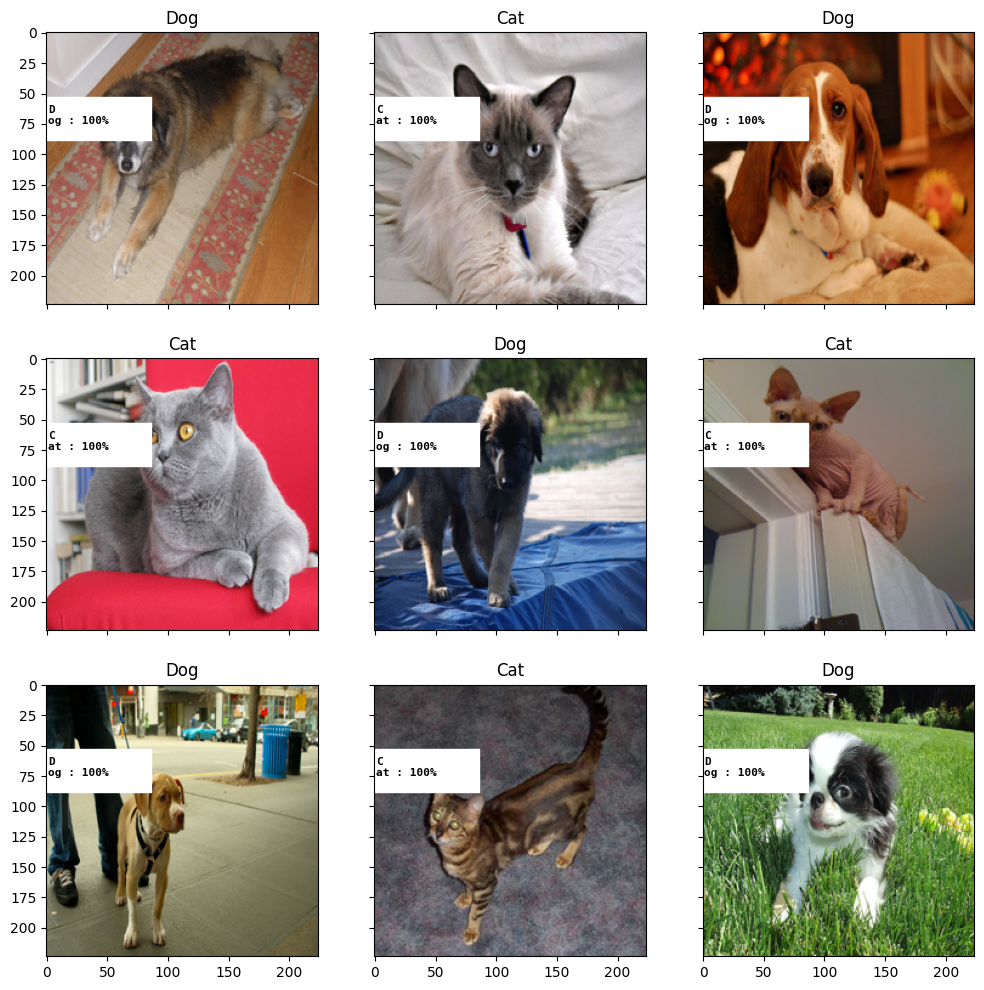

In [24]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label) // 2] + '\n' + predicted_label[len(predicted_label) // 2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

## Confusion matrix

Матрица ошибок (Confusion matrix) --- это важный инструмент, который используется для оценки производительности модели классификации. Она представляет собой таблицу, которая позволяет визуализировать и анализировать результаты классификации на основе истинных и предсказанных значений.

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [26]:
idxs = list(range(0, len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)
y_real = [val_dataset[id][1] for id in idxs]
y_pred = torch.Tensor(probs_ims).argmax(dim=1).tolist()

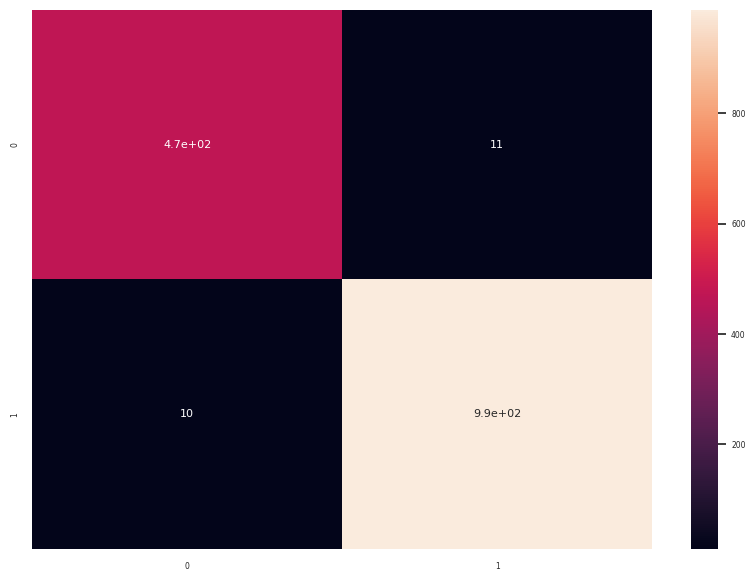

In [27]:
array = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10, 7))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})
plt.show()

In [29]:
print(array)

[[469  11]
 [ 10 988]]


#### Соотношения классов с лейблами


In [28]:
[x for x in zip(train_dataset.label_encoder.classes_,
train_dataset.label_encoder.transform(list(train_dataset.label_encoder.classes_)))]

[('Cat', 0), ('Dog', 1)]